<a href="https://colab.research.google.com/github/ivn-srg/data-analysis-course-omsu/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5%206/%D0%9A%D0%BE%D0%BC%D0%BF%D0%BB%D0%B5%D0%BA%D1%81%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.diagnostic import linear_reset
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import t
from scipy import stats
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinear(data):
  # Допустим, у нас есть DataFrame df с признаками
  X = sm.add_constant(data)  # Добавляем константу

  # Считаем VIF для каждой переменной
  vif_data = pd.DataFrame()
  vif_data["Feature"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  print("📊 Проверка мультиколлинеарности (VIF):\n")
  print(vif_data)

  # Выводим итоговое заключение
  problematic_features = vif_data[vif_data["VIF"] > 5]["Feature"].tolist()

  if not problematic_features:
      print("\n✅ Проблем с мультиколлинеарностью нет! Все признаки в порядке.")
  else:
      print("\n⚠️ Обнаружена мультиколлинеарность!")
      for feature in problematic_features:
          vif_value = vif_data[vif_data["Feature"] == feature]["VIF"].values[0]
          if vif_value > 10:
              print(f"❌ Переменная '{feature}' имеет VIF = {vif_value:.2f} (очень сильная мультиколлинеарность!) — рекомендуется удалить или преобразовать.")
          else:
              print(f"⚠️ Переменная '{feature}' имеет VIF = {vif_value:.2f} (умеренная мультиколлинеарность) — стоит проверить зависимость с другими предикторами.")


def draw_plot(y_test, y_pred):
  plt.figure(figsize=(8,6))
  plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='b')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs Predicted Values')
  plt.plot([y.min(), y.max()], [y.min(), y.max()], ls='--', c='red')
  plt.show()

def draw_corr_matrix(data, figsize=(8, 6)):
  # Вычисление корреляционной матрицы
  corr_matrix = data.corr()

  # Создание маски для верхней треугольной части(просто для красоты и удобства)
  # Функция np.triu создает верхнюю треугольную матрицу из массива единиц (np.ones_like),
  # где все элементы выше главной диагонали равны True, а остальные — False.
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Построение тепловой карты
  plt.figure(figsize=figsize)
  sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
  plt.title("Корреляционная матрица (только нижняя половина)")
  plt.show()

def calc_test_ramsey(model):
  reset_test = linear_reset(model, power=3, test_type='fitted', use_f=True)

  # Извлечение p-value
  p_value = reset_test.pvalue

  # Интерпретация результатов теста Рамсея
  if p_value < 0.05:
      result_text = "Нулевая гипотеза отвергается: модель специфицирована неправильно."
      recommendation = ("Рекомендации: "
                        "1. Проверьте, не упущены ли важные переменные. "
                        "2. Учтите возможные нелинейные зависимости (например, добавьте полиномиальные признаки). "
                        "3. Рассмотрите взаимодействия между переменными.")
  else:
      result_text = "Нулевая гипотеза не отвергается: модель правильно специфицирована."
      recommendation = "Рекомендации: текущая спецификация модели достаточна. Можно продолжить анализ."

  # Вывод результатов теста Рамсея
  print("\nРезультаты теста Рамсея:")
  print(f"F-статистика: {reset_test.fvalue:.4f}")
  print(f"p-value: {p_value:.4f}")
  print(result_text)
  print(recommendation)

def calculate_metrics(y_test, y_pred):
  score = r2_score(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred) ** 0.5
  print('R² Score for Predictions:', score)
  print('RMSE Score for Predictions:', rmse)

def calculate_t_stats_and_p_values(model, X_train, y_train):
  # Получаем коэффициенты модели
  coefficients = model.coef_
  intercept = model.intercept_

  # Прогнозируем значения на обучающей выборке
  y_pred = model.predict(X_train)

  # Вычисляем остатки
  residuals = y_train - y_pred

  # Вычисляем среднеквадратическую ошибку
  mse = np.mean(residuals**2)

  # Стандартная ошибка для каждого коэффициента
  X_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # добавляем столбец единиц для intercept
  X_transpose = X_with_intercept.T
  X_inv = np.linalg.inv(X_transpose.dot(X_with_intercept))
  standard_errors = np.sqrt(np.diagonal(mse * X_inv))

  # Вычисляем t-статистики
  t_stats = coefficients / standard_errors[1:]  # исключаем intercept

  # Вычисляем p-value для t-статистики
  p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=X_train.shape[0] - X_train.shape[1] - 1))

  # Создаем DataFrame для отображения
  result_df = pd.DataFrame({
    'Predictor': X_train.columns,
    'Coefficient': coefficients,
    'Standard Error': standard_errors[1:],  # исключаем intercept
    't-Statistic': t_stats,
    'p-Value': p_values
  })

  return result_df


# Вопросы для исследования

## 🔥 1. Анализ покупательского поведения
✅ Какие категории товаров покупают чаще всего?

✅ Как меняется средняя сумма покупки в зависимости от штата?

✅ Какие способы оплаты наиболее популярны?

✅ Есть ли сезонные тренды в покупках?

## 📈 2. Финансовая аналитика

✅ Какая доля покупок совершается через кредитные карты, PayPal, UPI и другие методы?

✅ Какова сумма общих продаж за определённые периоды (месяц, квартал, год)?

✅ Как изменяется суммарный доход от клиентов по штатам?

✅ Какие категории товаров приносят наибольший доход?

## 🔮 4. Прогнозирование и машинное обучение
✅ Можно ли спрогнозировать сумму покупки?

✅ Какие факторы сильнее всего влияют на покупательскую активность?

In [28]:
df = pd.read_csv('/content/drive/MyDrive/Занятия АД 2 семестр 2025/Ресурсы/Данные/Big Data/shopping_trends_updated.csv', parse_dates=True)

In [29]:
df

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,Weekly
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,Quarterly
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,Weekly


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [5]:
# Какие категории товаров покупают чаще всего?
df['Category'].value_counts()

,count
Category,
Clothing,1737
Accessories,1240
Footwear,599
Outerwear,324


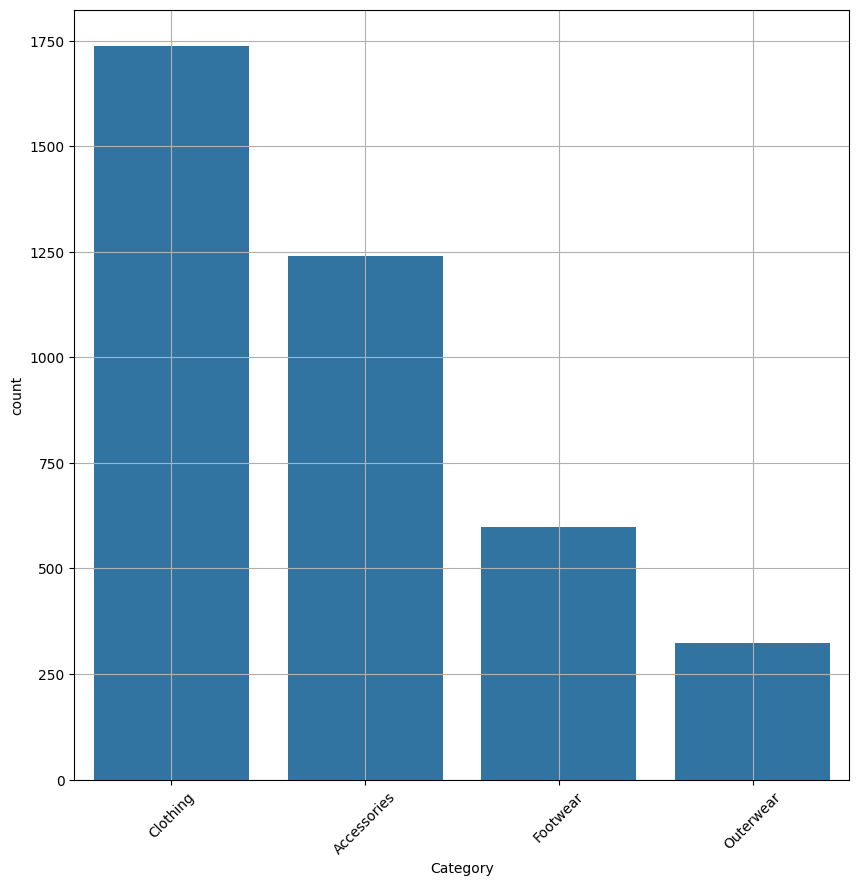

In [34]:
df_group_category = df['Category'].value_counts()

plt.figure(figsize=(10,10))
sns.barplot(df_group_category)
plt.xticks(rotation=45)
plt.grid()
plt.show()

Средняя сумма покупки по странам:
Location
Alabama           59.112360
Alaska            67.597222
Arizona           66.553846
Arkansas          61.113924
California        59.000000
Colorado          56.293333
Connecticut       54.179487
Delaware          55.325581
Florida           55.852941
Georgia           58.797468
Hawaii            57.723077
Idaho             60.075269
Illinois          61.054348
Indiana           58.924051
Iowa              60.884058
Kansas            54.555556
Kentucky          55.721519
Louisiana         57.714286
Maine             56.987013
Maryland          55.755814
Massachusetts     60.888889
Michigan          62.095890
Minnesota         56.556818
Mississippi       61.037500
Missouri          57.913580
Montana           60.250000
Nebraska          59.448276
Nevada            63.379310
New Hampshire     59.422535
New Jersey        56.746269
New Mexico        61.901235
New York          60.425287
North Carolina    60.794872
North Dakota      62.891566
Ohio 

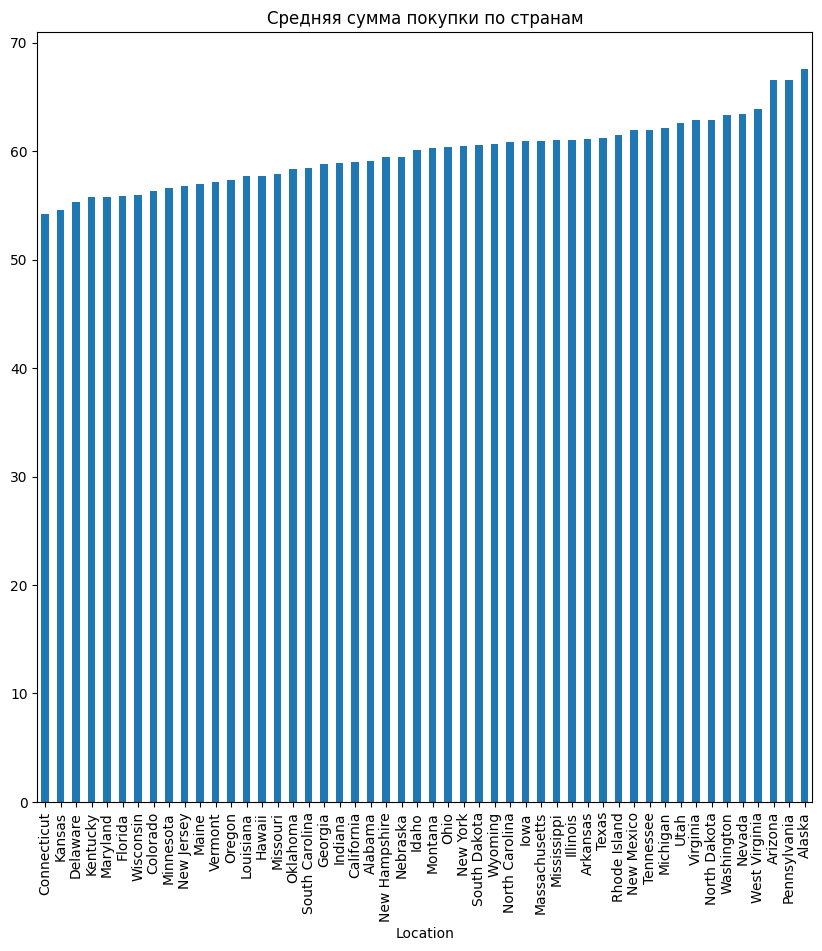

In [37]:
# 2. Как меняется средняя сумма покупки в зависимости от штата?
country_avg_purchase = df.groupby('Location')['Purchase Amount (USD)'].mean()
print("Средняя сумма покупки по странам:")
print(country_avg_purchase)

plt.figure(figsize=(10,10))
country_avg_purchase.sort_values().plot(kind='bar', title='Средняя сумма покупки по странам')
plt.show()

Популярность способов оплаты:
Payment Method
PayPal           677
Credit Card      671
Cash             670
Debit Card       636
Venmo            634
Bank Transfer    612
Name: count, dtype: int64


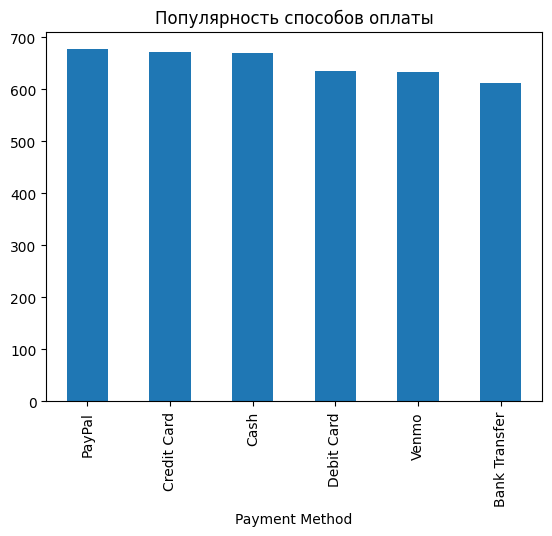

In [8]:
# 3. Какие способы оплаты наиболее популярны?
payment_methods = df['Payment Method'].value_counts()
print("Популярность способов оплаты:")
print(payment_methods)
payment_methods.plot(kind='bar', title='Популярность способов оплаты')
plt.show()

<Axes: xlabel='Payment Method'>

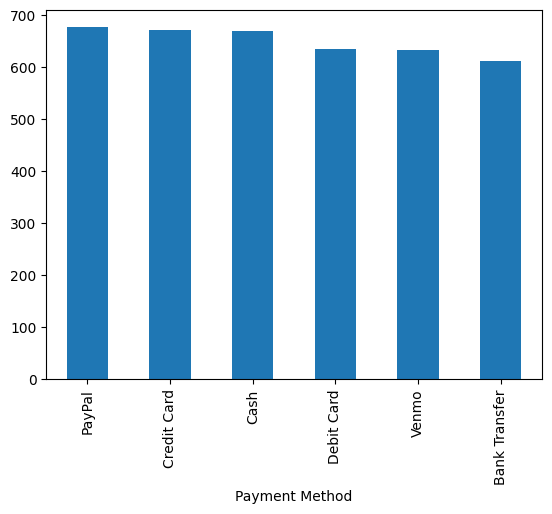

In [9]:
# 6. Доля покупок по методам оплаты
payment_share = df['Payment Method'].value_counts()

payment_share.plot(kind='bar')

Общий доход по странам:
Location
Alabama           5261
Alaska            4867
Arizona           4326
Arkansas          4828
California        5605
Colorado          4222
Connecticut       4226
Delaware          4758
Florida           3798
Georgia           4645
Hawaii            3752
Idaho             5587
Illinois          5617
Indiana           4655
Iowa              4201
Kansas            3437
Kentucky          4402
Louisiana         4848
Maine             4388
Maryland          4795
Massachusetts     4384
Michigan          4533
Minnesota         4977
Mississippi       4883
Missouri          4691
Montana           5784
Nebraska          5172
Nevada            5514
New Hampshire     4219
New Jersey        3802
New Mexico        5014
New York          5257
North Carolina    4742
North Dakota      5220
Ohio              4649
Oklahoma          4376
Oregon            4243
Pennsylvania      4926
Rhode Island      3871
South Carolina    4439
South Dakota      4236
Tennessee         4772
T

<Axes: xlabel='Location'>

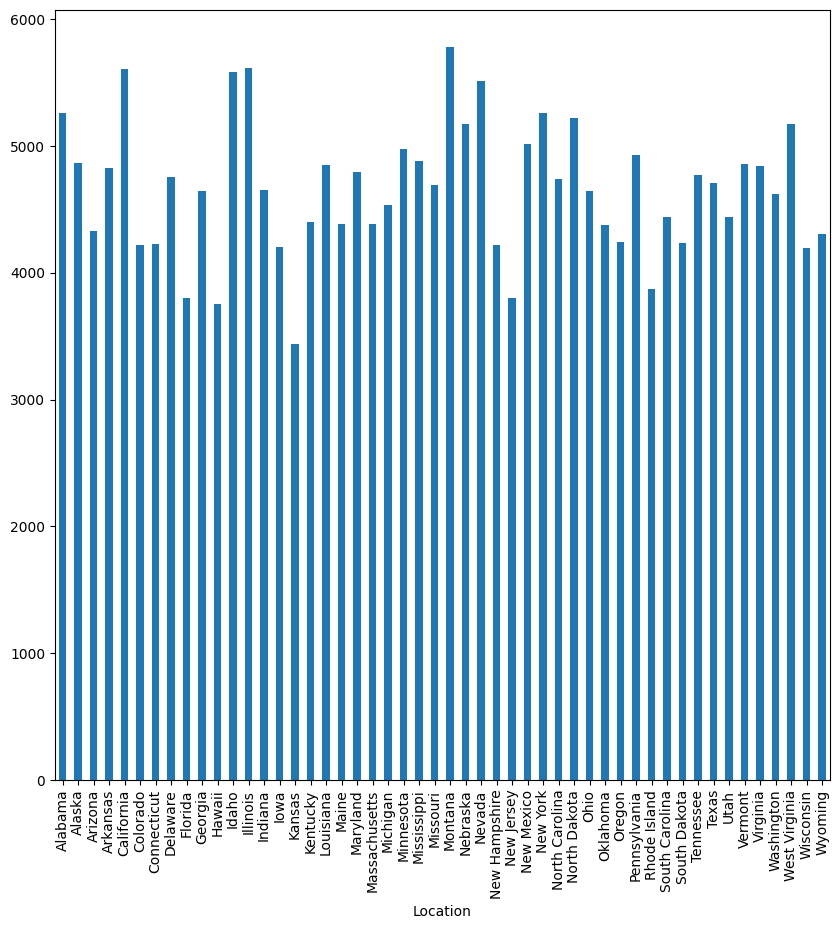

In [39]:
# 8. Изменение суммарного дохода по штатам
country_revenue = df.groupby('Location')['Purchase Amount (USD)'].sum()
print("Общий доход по странам:")
print(country_revenue)

plt.figure(figsize=(10,10))
country_revenue.plot(kind='bar')

In [ ]:
df.columns

In [40]:
# 11. Прогнозирование суммы покупки
enc = LabelEncoder()
features_cat = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season',
      'Subscription Status', 'Shipping Type',
       'Discount Applied', 'Promo Code Used',
       'Payment Method', 'Frequency of Purchases']

for col in features_cat:
  df[col] = enc.fit_transform(df[col])

features = [
    'Age', 'Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Shipping Type',
       'Discount Applied', 'Promo Code Used',
    'Previous Purchases',
       'Payment Method', 'Frequency of Purchases'
]

df.dropna(inplace=True)

X = df[features]
y = df['Purchase Amount (USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

calculate_metrics(y_test, predictions)

R² Score for Predictions: -0.013737160030638407
RMSE Score for Predictions: 23.817418927888518


R² Score for Predictions: -0.013737160030637519
RMSE Score for Predictions: 23.817418927888504


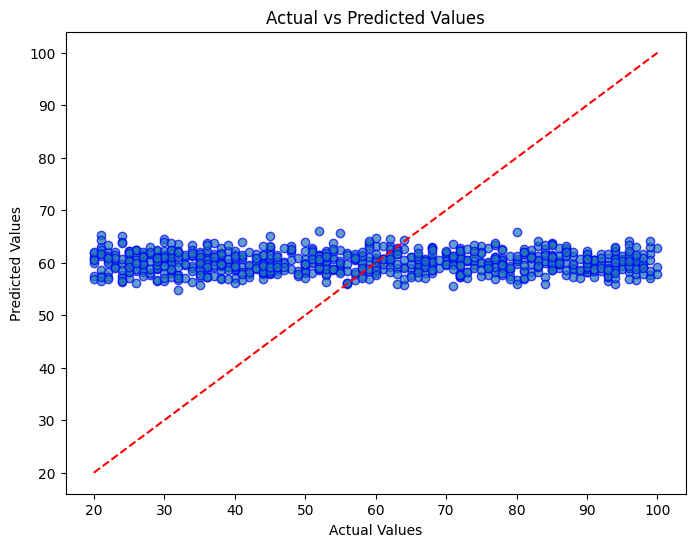

In [41]:
# Добавляем константу для intercept (важно для statsmodels!)
X_train_sm = sm.add_constant(X_train, has_constant='skip')
X_test_sm = sm.add_constant(X_test, has_constant='skip')

# Модель OLS
model = sm.OLS(y_train, X_train_sm).fit()

# Предсказания
y_pred_ols = model.predict(X_test_sm)

# подсчет метрик
calculate_metrics(y_test, y_pred_ols)

# рисование графика
draw_plot(y_test, y_pred_ols)

In [15]:
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Purchase Amount (USD)   R-squared:                       0.006
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     1.247
Date:                   Sat, 05 Apr 2025   Prob (F-statistic):              0.229
Time:                           04:15:01   Log-Likelihood:                -14291.
No. Observations:                   3120   AIC:                         2.861e+04
Df Residuals:                       3104   BIC:                         2.871e+04
Df Model:                             15                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [ ]:
calc_test_ramsey(model)

In [ ]:
check_multicollinear(X)

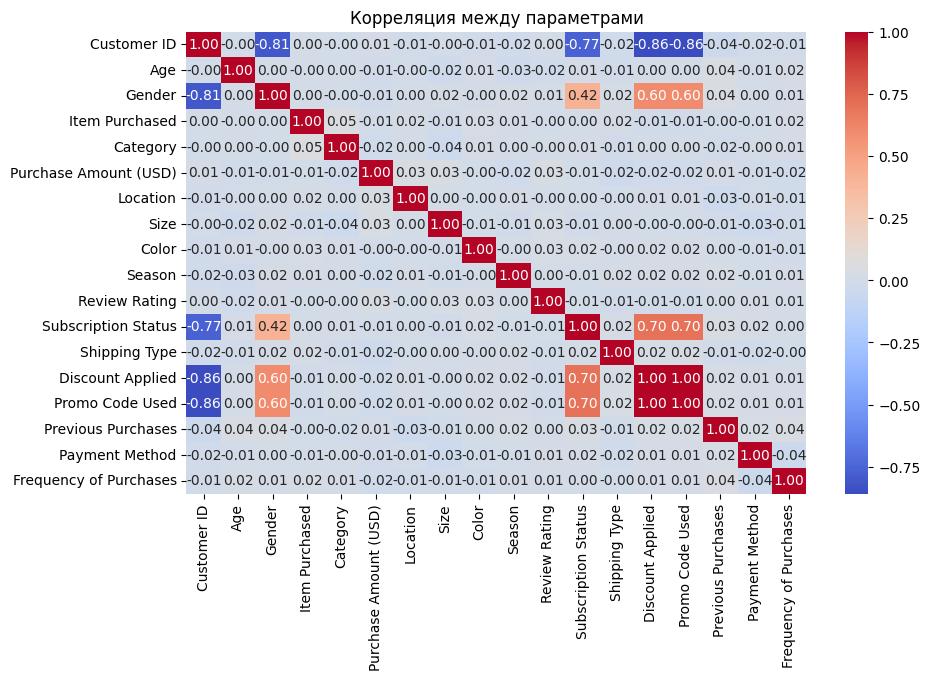

In [42]:
# 14. Какие факторы влияют на покупательскую активность?
correlation = df.select_dtypes("number").corr()

plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляция между параметрами")
plt.show()


In [43]:
df = pd.read_csv('/content/suicides.csv')

In [45]:
df[' gdp_for_year ($) ']

,gdp_for_year ($)
0,"2,156,624,900"
1,"2,156,624,900"
2,"2,156,624,900"
3,"2,156,624,900"
4,"2,156,624,900"
...,...
27815,"63,067,077,179"
27816,"63,067,077,179"
27817,"63,067,077,179"
27818,"63,067,077,179"


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [20]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [46]:
df[' gdp_for_year ($) '] = df[' gdp_for_year ($) '].str.replace(",",'').astype(float)

In [47]:
# 11. Прогнозирование суммы покупки
enc = LabelEncoder()
features_cat = ['country', 'sex', 'age', 'gdp_per_capita ($)', 'generation']

for col in features_cat:
  df[col] = enc.fit_transform(df[col])

features = [
    'country', 'year', 'sex', 'age', 'population',
       'suicides/100k pop', 'HDI for year',' gdp_for_year ($) ',
        'gdp_per_capita ($)', 'generation'
]

df.dropna(inplace=True)

X = df[features]
y = df['suicides_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

calculate_metrics(y_test, predictions)

R² Score for Predictions: 0.602242720228187
RMSE Score for Predictions: 428.1069968625332


R² Score for Predictions: 0.6089377771101884
RMSE Score for Predictions: 424.48875476887474


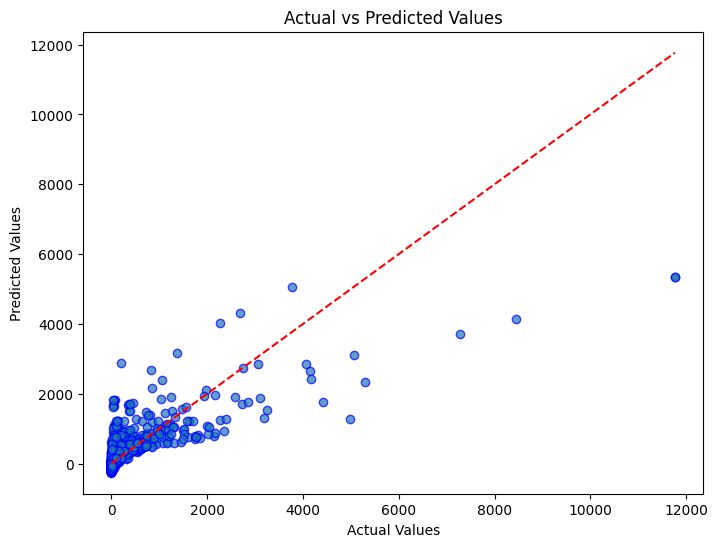

In [48]:
# Добавляем константу для intercept (важно для statsmodels!)
X_train_sm = sm.add_constant(X_train, has_constant='skip')
X_test_sm = sm.add_constant(X_test, has_constant='skip')

# Модель OLS
model = sm.OLS(y_train, X_train_sm).fit()

# Предсказания
y_pred_ols = model.predict(X_test_sm)

# подсчет метрик
calculate_metrics(y_test, y_pred_ols)

# рисование графика
draw_plot(y_test, y_pred_ols)

In [49]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            suicides_no   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     951.6
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:14:17   Log-Likelihood:                -50388.
No. Observations:                6691   AIC:                         1.008e+05
Df Residuals:                    6681   BIC:                         1.009e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2494.8740   1390

In [25]:
calc_test_ramsey(model)


Результаты теста Рамсея:
F-статистика: 420.4712
p-value: 0.0000
Нулевая гипотеза отвергается: модель специфицирована неправильно.
Рекомендации: 1. Проверьте, не упущены ли важные переменные. 2. Учтите возможные нелинейные зависимости (например, добавьте полиномиальные признаки). 3. Рассмотрите взаимодействия между переменными.


In [26]:
check_multicollinear(X)

📊 Проверка мультиколлинеарности (VIF):

               Feature       VIF
0                const  0.000000
1              country  1.041547
2                 year  1.245917
3                  sex  1.218425
4                  age  1.062323
5           population  2.459020
6    suicides/100k pop  1.323962
7         HDI for year  6.955972
8    gdp_for_year ($)   2.675122
9   gdp_per_capita ($)  6.724610
10          generation  1.088893

⚠️ Обнаружена мультиколлинеарность!
⚠️ Переменная 'HDI for year' имеет VIF = 6.96 (умеренная мультиколлинеарность) — стоит проверить зависимость с другими предикторами.
⚠️ Переменная 'gdp_per_capita ($)' имеет VIF = 6.72 (умеренная мультиколлинеарность) — стоит проверить зависимость с другими предикторами.


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


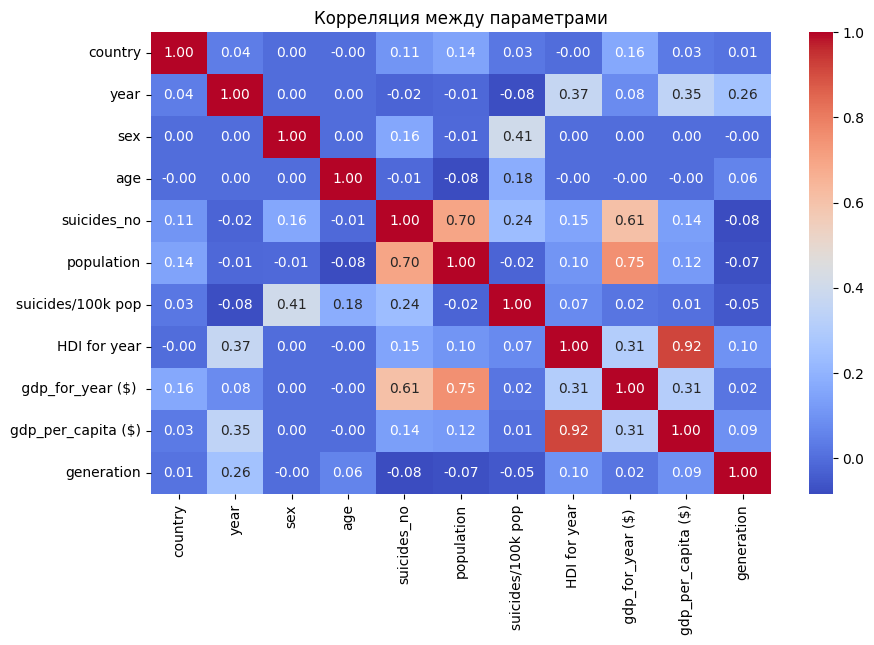

In [50]:
# 14. Корреляция?
correlation = df.select_dtypes("number").corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляция между параметрами")
plt.show()
